# Transfer Learning

This notebook explores different efforts for transfer learning applied to MNIST and CIFAR with augmented images.

In [1]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import torch
import neuralnetworkclassifier as nnc
import dataset_manipulations as dm
import perturb as per
import numpy as np
import mlutils as ml
import pickle
import os

import matplotlib.pyplot as plt

In [2]:
Xtrain, Ttrain = dm.load_cifar_10('./cifar-10-batches-py/data_batch_*')
Xtest, Ttest = dm.load_cifar_10('./cifar-10-batches-py/test_batch')

In [3]:
noise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.05))
noise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.05))

In [4]:
morenoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.1))
morenoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.1)) 

In [5]:
lessnoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.025))
lessnoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.025)) 

In [6]:
import imp
imp.reload(nnc)
imp.reload(per)

<module 'perturb' from '../src/perturb.py'>

## Load before you Train

FYI, if this clean model has already been trained, you should just load it instead of training again!

In [15]:
if os.path.exists('./pretrained_cifar_clean.pkl'):
    nnet = nnc.NeuralNetwork_Convolutional.load_network('./pretrained_cifar_clean.pkl')
else:
    nnet = per.train_cifar(Xtrain, Ttrain, verbose=True, random_seed=12)

In [16]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=3,
                            image_size=32,
                            n_units_in_conv_layers=[64, 64, 128, 128, 256, 256, 512, 512],
                            kernels_size_and_stride=[(3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 1)],
                            max_pooling_kernels_and_stride=[(), (2, 2), (), (2, 2), (), (2, 2), (), (2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output_0): ReLU()
  (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
if not os.path.exists('./pretrained_cifar_clean.pkl'):
    print('Saving network')
    nnet.save_network('./pretrained_cifar_clean.pkl')

In [18]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(86.15, 84.11999999999999, 70.26, 31.419999999999998)

In [19]:
transfer_network = nnet.transfer_learn_setup([256, 512], overwrite_network=True, freeze=True)
transfer_network

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.2, inplace=False)
  (16): Conv2d(128, 256, kernel_size=(3, 3),

In [20]:
nnet.train(noise_Xtrain, Ttrain, n_epochs=5, batch_size=200,
           optim='Adam', learning_rate=0.0005, verbose=True)

Epoch 1 error 0.22122
Epoch 2 error 0.16778
Epoch 3 error 0.15169
Epoch 4 error 0.13696
Epoch 5 error 0.14111


In [21]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(82.36, 83.35000000000001, 81.58, 59.0)

In [32]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

(96.76, 96.89999999999999, 97.11, 96.96000000000001)

## Plotting Transfer Learning Results

In [34]:
res_list = []
for ds, name in zip([lessnoise_Xtrain, noise_Xtrain, morenoise_Xtrain], ['0.025v', '0.05v', '0.1v']):
    nnet = nnc.NeuralNetwork_Convolutional.load_network('./pretrained_mnist_clean.pkl')
    nnet.transfer_learn_setup([256], freeze=False)
    nnet.train(ds, Ttrain, n_epochs=10, batch_size=200, optim='Adam', learning_rate=0.0005, verbose=True)
    
    res_list.append((name, per.run_increasing_noise(nnet, Xtest, Ttest, trials_per_step=1)))

Epoch 1 error 0.28583
Epoch 2 error 0.19008
Epoch 3 error 0.19235
Epoch 4 error 0.20943
Epoch 5 error 0.16437
Epoch 6 error 0.12645
Epoch 7 error 0.17384
Epoch 8 error 0.15913
Epoch 9 error 0.15459
Epoch 10 error 0.20478


FloatProgress(value=0.0, max=5.0)

Epoch 1 error 0.29780
Epoch 2 error 0.21537
Epoch 3 error 0.21005
Epoch 4 error 0.22976
Epoch 5 error 0.17765
Epoch 6 error 0.13739
Epoch 7 error 0.19422
Epoch 8 error 0.17500
Epoch 9 error 0.16526
Epoch 10 error 0.20479


FloatProgress(value=0.0, max=5.0)

Epoch 1 error 0.33810
Epoch 2 error 0.22316
Epoch 3 error 0.21486
Epoch 4 error 0.24711
Epoch 5 error 0.20665
Epoch 6 error 0.16554
Epoch 7 error 0.21958
Epoch 8 error 0.17969
Epoch 9 error 0.14288
Epoch 10 error 0.19367


FloatProgress(value=0.0, max=5.0)

In [35]:
res_list

[('0.025v',
  (array([0.001  , 0.01325, 0.0255 , 0.03775, 0.05   ]),
   array([97.45, 97.4 , 97.31, 97.13, 96.71]),
   array([0., 0., 0., 0., 0.]))),
 ('0.05v',
  (array([0.001  , 0.01325, 0.0255 , 0.03775, 0.05   ]),
   array([97.42, 97.4 , 97.44, 97.34, 97.31]),
   array([0., 0., 0., 0., 0.]))),
 ('0.1v',
  (array([0.001  , 0.01325, 0.0255 , 0.03775, 0.05   ]),
   array([97.07, 97.06, 97.1 , 97.07, 97.14]),
   array([0., 0., 0., 0., 0.])))]

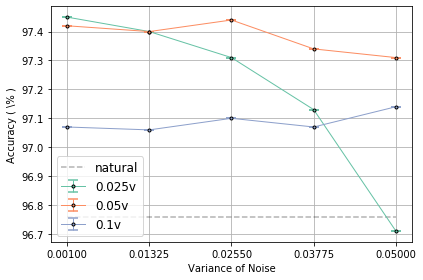

In [36]:
per.plot_increasing_noise(clean_pct, res_list, (0.001, 0.05), 5, 'delme.pdf')

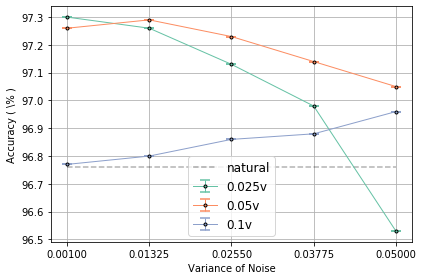

In [33]:
per.plot_increasing_noise(clean_pct, res_list, (0.001, 0.05), 5, 'delme.pdf')

In [ ]:
per.test_increasing_noise(nnet, Xtest, Ttest, var_range=(0.001, 0.1), trials_per_step=1)

## Transfer Learning on MNIST

In [25]:
Xtrain, Ttrain, Xtest, Ttest, _, _ = dm.load_mnist('./mnist.pkl.gz')

In [26]:
noise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.05))
noise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.05))

In [27]:
morenoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.1))
morenoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.1)) 

In [28]:
lessnoise_Xtrain = dm.apply_manipulations(Xtrain, per_func=lambda x: per.add_image_noise(x, variance=0.025))
lessnoise_Xtest = dm.apply_manipulations(Xtest, per_func=lambda x: per.add_image_noise(x, variance=0.025)) 

In [ ]:
if os.path.exists('./pretrained_mnist_clean.pkl'):
    nnet = nnc.NeuralNetwork_Convolutional.load_network('./pretrained_mnist_clean.pkl')
else:
    nnet = per.train_mnist(Xtrain, Ttrain, verbose=True)

In [ ]:
nnet

In [ ]:
if not os.path.exists('./pretrained_mnist_clean.pkl'):
    print('Saving network')
    nnet.save_network('./pretrained_mnist_clean.pkl')

In [ ]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

In [ ]:
nnet.transfer_learn_setup([256], freeze=True)

In [ ]:
nnet.train(noise_Xtrain, Ttrain, n_epochs=20, batch_size=200,
           optim='Adam', learning_rate=0.0005, verbose=True)

In [ ]:
clean_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, Xtest, 100))
noise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, noise_Xtest, 100))
lessnoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, lessnoise_Xtest, 100))
morenoise_pct = ml.percent_correct(Ttest, ml.batched_use(nnet, morenoise_Xtest, 100))
(clean_pct, lessnoise_pct, noise_pct, morenoise_pct)

In [ ]:
res_list = []
res_list.append()

In [ ]:
per.run_increasing_noise(nnet, Xtest, Ttest, var_range=(0.001, 0.1))